# SpoilerShield: NLP Text Classification Project

**Author:** Scott Stearns  
**Notebook:** Kaggle EDA & Modeling Workflow

---

## Table of Contents
1. [Details of the Dataset](#details)
2. [Exploratory Data Analysis](#eda)
3. [Model Training and Hyperparameter Search](#training)
4. [Model Evaluation](#evaluation)

---

This notebook demonstrates a professional, modular workflow for text classification.

In [ ]:
# Imports for general processing
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Imports for preparing data for models
!pip install transformers --quiet

from transformers import BertTokenizer
import torch
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# Mount drive for Google Colab - set to False for other environments
if True:
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def detect_environment():
    if (os.path.exists("/kaggle/input") and
        len(os.listdir("/kaggle/input")) > 0):
        return "kaggle"
    elif os.path.ismount('/content/drive'):
        return "colab"
    else:
        return "local"

In [ ]:
env = detect_environment()
print(f"Detected environment: {env}")

Detected environment: colab


In [ ]:
# Set up paths for Kaggle, Google Colab or local environment
def set_paths(env):
    if env == "kaggle":
        src_path = '/kaggle/input/spoiler-shield-code/spoiler_shield_code/implementation/src'
        data_path = '/kaggle/input/spoiler-shield-code/spoiler_shield_code/implementation/src/data'
    elif env == 'colab':
        src_path = '/content/drive/MyDrive/IK Course Materials/SpoilerShield/implementation/src'
        data_path = '/content/drive/MyDrive/IK Course Materials/SpoilerShield/implementation/src/data'
    else:
        # Local: adjust as needed
        src_path = os.path.abspath(os.path.join(os.getcwd(), '../../implementation/src'))
    if src_path not in sys.path:
        sys.path.insert(0, src_path)
    return src_path, data_path

src_path, data_path  = set_paths(env)

imdb_movie_reviews_path = os.path.join(data_path, 'train_reviews.json')
imdb_movie_details_path = os.path.join(data_path, 'IMDB_movie_details.json')
os.chdir(src_path)

In [ ]:
os.listdir(os.getcwd())

['features', 'visualization', 'eda', 'data', 'utils', 'evaluation', 'models']

In [ ]:
os.path.dirname(os.path.abspath("__file__"))

'/content/drive/MyDrive/IK Course Materials/SpoilerShield/implementation/src'

In [ ]:
# Import utilities and class definitions
from eda.text_analyzer import TextAnalyzer
from eda.visualization import TextVisualizer
from eda.data_loader import DataLoader

In [ ]:
# Load the training and test data sets and confirm the dataframes are uploaded.
print(f'Loading data from {imdb_movie_reviews_path} and {imdb_movie_details_path}')
data_loader = DataLoader(imdb_movie_reviews_path, imdb_movie_details_path)
df_reviews = data_loader.load_imdb_movie_reviews()
df_details = data_loader.load_imdb_movie_details()


Loading data from /content/drive/MyDrive/IK Course Materials/SpoilerShield/implementation/src/data/train_reviews.json and /content/drive/MyDrive/IK Course Materials/SpoilerShield/implementation/src/data/IMDB_movie_details.json


In [ ]:
df_reviews.head()

,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary
0,21 August 1999,tt0129387,ur0286745,False,"While Stiller, Diaz, and to some degree Dillon...",3,For those who think the 3 Stooges are funny.
1,7 June 2002,tt0285742,ur1785392,False,I realize that this film has received seriousl...,8,"flawed, but all the better for it"
2,10 May 2015,tt0362227,ur23538961,True,"Sometimes you say for some role: ""this role co...",7,"Great performances, interesting topic"
3,2 September 1998,tt0054215,ur0068788,False,One of the all-time greats. To say more is un...,10,Classic
4,8 October 2003,tt0129167,ur2049571,False,"Even years after its release, I still find The...",10,Wonderful for kids and adults


In [ ]:
df_details.head()

,movie_id,plot_summary,duration,genre,rating,release_date,plot_synopsis
0,tt0105112,"Former CIA analyst, Jack Ryan is in England wi...",1h 57min,"[Action, Thriller]",6.9,1992-06-05,"Jack Ryan (Ford) is on a ""working vacation"" in..."
1,tt1204975,"Billy (Michael Douglas), Paddy (Robert De Niro...",1h 45min,[Comedy],6.6,2013-11-01,Four boys around the age of 10 are friends in ...
2,tt0243655,"The setting is Camp Firewood, the year 1981. I...",1h 37min,"[Comedy, Romance]",6.7,2002-04-11,
3,tt0040897,"Fred C. Dobbs and Bob Curtin, both down on the...",2h 6min,"[Adventure, Drama, Western]",8.3,1948-01-24,Fred Dobbs (Humphrey Bogart) and Bob Curtin (T...
4,tt0126886,Tracy Flick is running unopposed for this year...,1h 43min,"[Comedy, Drama, Romance]",7.3,1999-05-07,Jim McAllister (Matthew Broderick) is a much-a...


---

## 1. <a id='details'></a>Details of the Dataset

In this section, we provide a comprehensive overview of the dataset, including its size, features, target variables, and data types.


In [ ]:
# Display dataset specs
print('Reviews shape:', df_reviews.shape)
print('Details shape:', df_details.shape)
print('Review columns:', df_reviews.columns.tolist())
print('Details columns:', df_details.columns.tolist())
print('Review dtypes:')
print(df_reviews.dtypes)
print('Details dtypes:')
print(df_details.dtypes)
print('Sample reviews:')
display(df_reviews.head())
print('Sample details:')
display(df_details.head())
print('Missing values in reviews:')
print(df_reviews.isnull().sum())
print('Missing values in details:')
print(df_details.isnull().sum())


Reviews shape: (79999, 7)
Details shape: (1572, 7)
Review columns: ['review_date', 'movie_id', 'user_id', 'is_spoiler', 'review_text', 'rating', 'review_summary']
Details columns: ['movie_id', 'plot_summary', 'duration', 'genre', 'rating', 'release_date', 'plot_synopsis']
Review dtypes:
review_date       object
movie_id          object
user_id           object
is_spoiler          bool
review_text       object
rating             int64
review_summary    object
dtype: object
Details dtypes:
movie_id          object
plot_summary      object
duration          object
genre             object
rating           float64
release_date      object
plot_synopsis     object
dtype: object
Sample reviews:


,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary
0,21 August 1999,tt0129387,ur0286745,False,"While Stiller, Diaz, and to some degree Dillon...",3,For those who think the 3 Stooges are funny.
1,7 June 2002,tt0285742,ur1785392,False,I realize that this film has received seriousl...,8,"flawed, but all the better for it"
2,10 May 2015,tt0362227,ur23538961,True,"Sometimes you say for some role: ""this role co...",7,"Great performances, interesting topic"
3,2 September 1998,tt0054215,ur0068788,False,One of the all-time greats. To say more is un...,10,Classic
4,8 October 2003,tt0129167,ur2049571,False,"Even years after its release, I still find The...",10,Wonderful for kids and adults


Sample details:


,movie_id,plot_summary,duration,genre,rating,release_date,plot_synopsis
0,tt0105112,"Former CIA analyst, Jack Ryan is in England wi...",1h 57min,"[Action, Thriller]",6.9,1992-06-05,"Jack Ryan (Ford) is on a ""working vacation"" in..."
1,tt1204975,"Billy (Michael Douglas), Paddy (Robert De Niro...",1h 45min,[Comedy],6.6,2013-11-01,Four boys around the age of 10 are friends in ...
2,tt0243655,"The setting is Camp Firewood, the year 1981. I...",1h 37min,"[Comedy, Romance]",6.7,2002-04-11,
3,tt0040897,"Fred C. Dobbs and Bob Curtin, both down on the...",2h 6min,"[Adventure, Drama, Western]",8.3,1948-01-24,Fred Dobbs (Humphrey Bogart) and Bob Curtin (T...
4,tt0126886,Tracy Flick is running unopposed for this year...,1h 43min,"[Comedy, Drama, Romance]",7.3,1999-05-07,Jim McAllister (Matthew Broderick) is a much-a...


Missing values in reviews:
review_date       0
movie_id          0
user_id           0
is_spoiler        0
review_text       0
rating            0
review_summary    0
dtype: int64
Missing values in details:
movie_id         0
plot_summary     0
duration         0
genre            0
rating           0
release_date     0
plot_synopsis    0
dtype: int64


---

## 2. <a id='eda'></a>Exploratory Data Analysis

Statistical analyses and visual examinations to uncover patterns, anomalies, and relationships within the dataset. Document findings to inform subsequent modeling decisions.

*Fill in with EDA code using TextAnalyzer and TextVisualizer as needed.*


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Top 20 most frequent words:
I         307337
's        211670
movie     192398
film      144492
The       141164
n't       125083
)         112436
(         108848
``         92946
''         90957
one        82000
like       71070
It         64102
good       55842
?          54096
story      50114
would      47361
really     45952
time       44502
see        44423
dtype: int64


/content/drive/MyDrive/IK Course Materials/SpoilerShield/implementation/src/eda/visualization.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=word_freq.index, y=word_freq.values, palette='viridis')


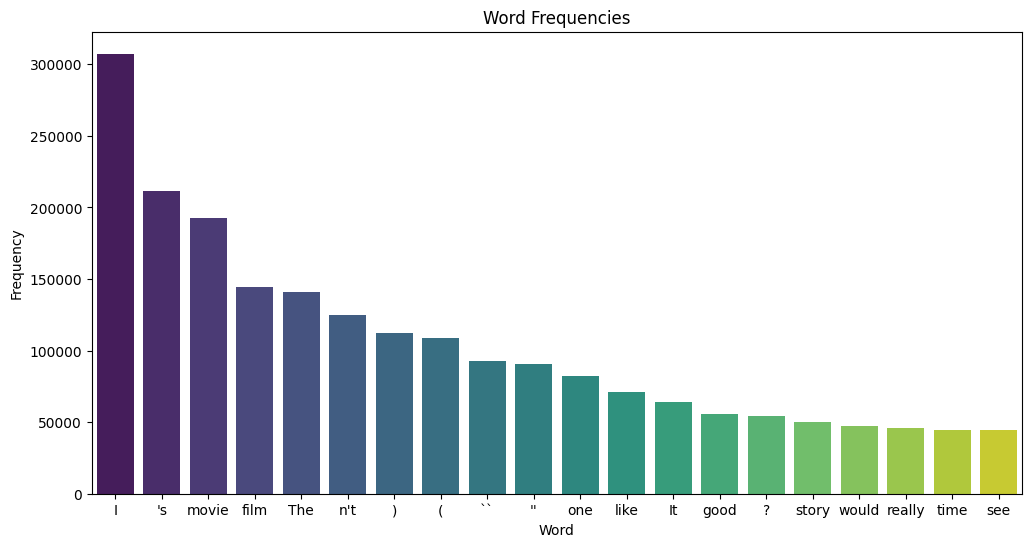


Class distribution:
Imbalance ratio: 2.80

Class counts:
is_spoiler
False    58961
True     21038
Name: count, dtype: int64

Class percentages:
is_spoiler
False    0.737022
True     0.262978
Name: count, dtype: float64


/content/drive/MyDrive/IK Course Materials/SpoilerShield/implementation/src/eda/visualization.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
/content/drive/MyDrive/IK Course Materials/SpoilerShield/implementation/src/eda/visualization.py:118: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_percentages.index, y=class_percentages.values, palette='viridis')


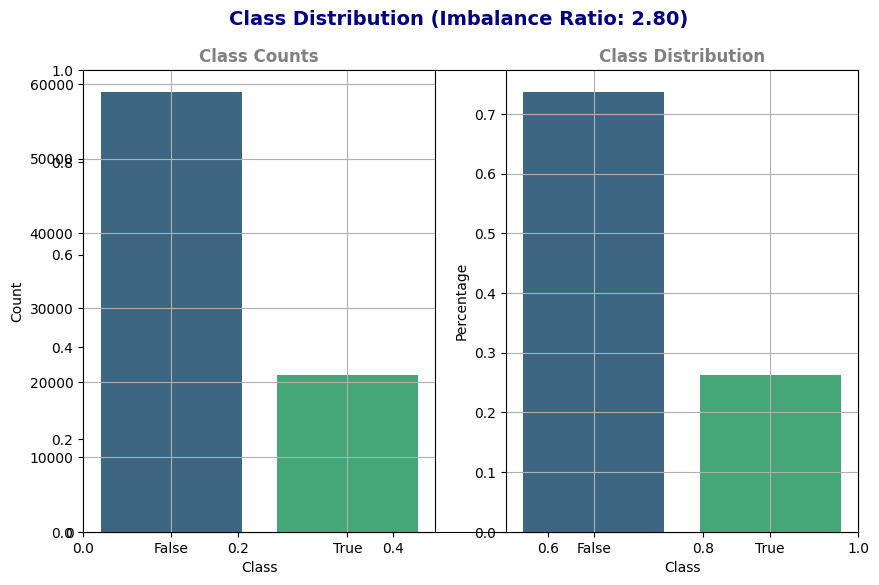

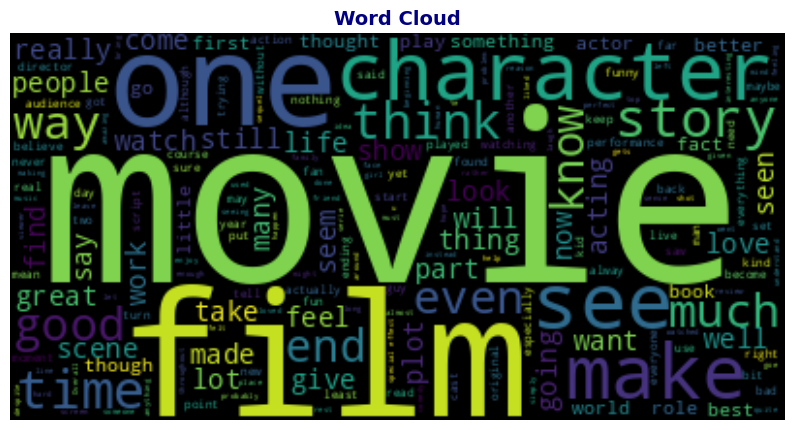

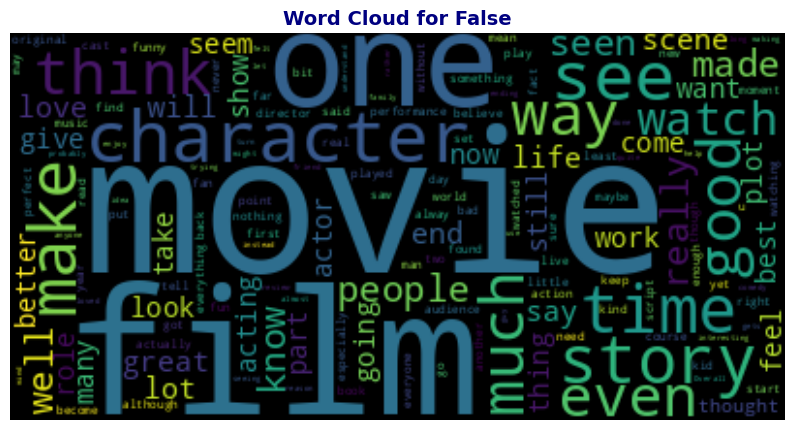

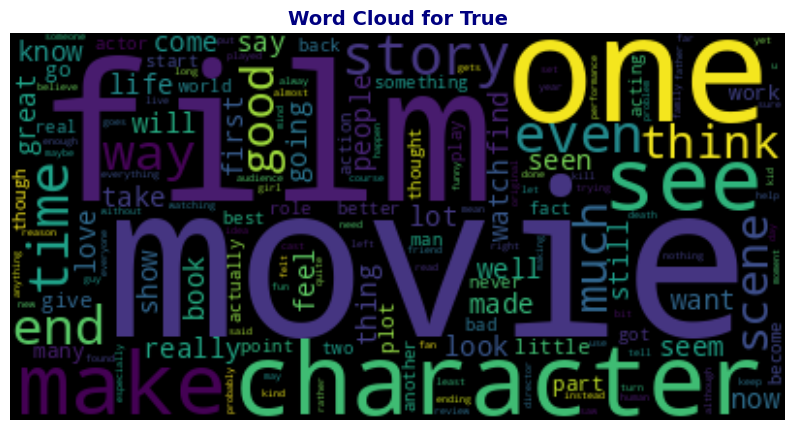


Document length statistics:
Mean length: 296.03 words
Median length: 216.00 words
Min length: 2 words
Max length: 2961 words


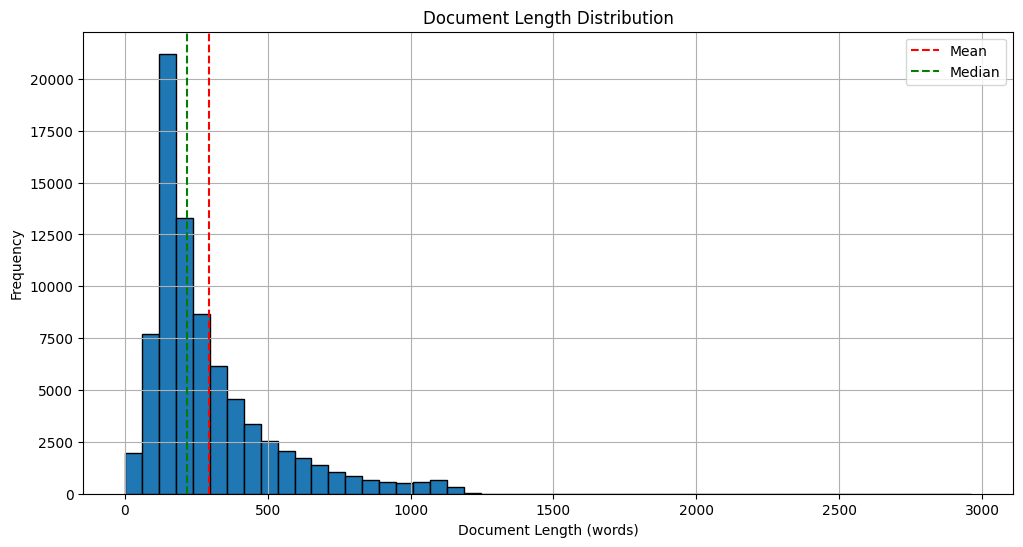

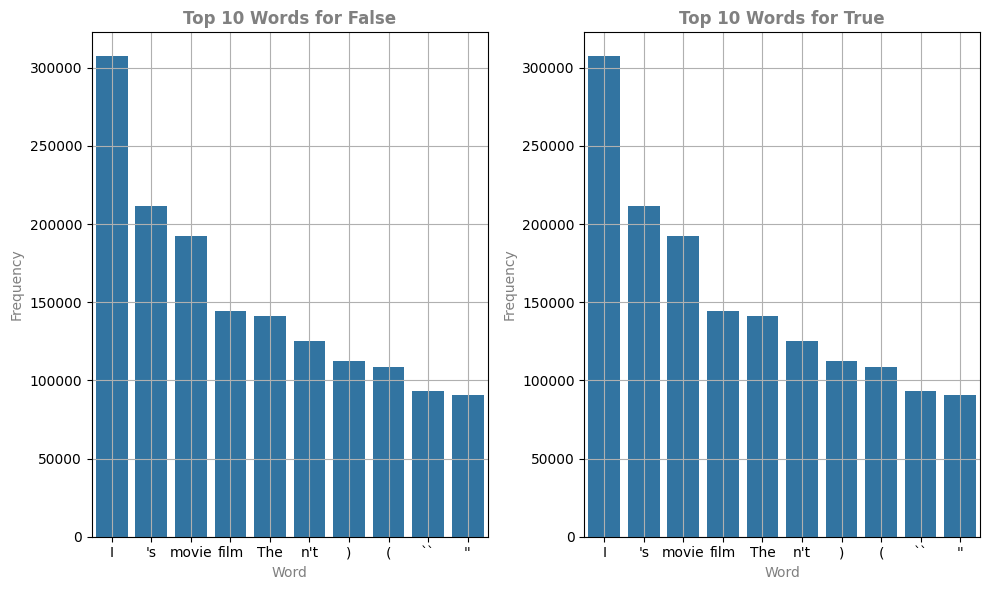

In [ ]:
# Initialize the analyzer and visualizer with the data
analyzer = TextAnalyzer(
    texts=df_reviews['review_text'],
    labels=df_reviews['is_spoiler']
)
visualizer = TextVisualizer(
    texts=df_reviews['review_text'],
    labels=df_reviews['is_spoiler']
)

# Example EDA tasks
# 1. Analyze word frequencies
word_freq = analyzer.analyze_word_frequency(n_top=20, remove_stopwords=True)
print("Top 20 most frequent words:")
print(word_freq)

# 2. Plot word frequencies
visualizer.plot_word_frequencies(n_top=20, remove_stopwords=True)

# 3. Analyze class distribution
class_counts, class_percentages, imbalance_ratio = analyzer.analyze_class_distribution()
print("\nClass distribution:")
print(f"Imbalance ratio: {imbalance_ratio:.2f}")
print("\nClass counts:")
print(class_counts)
print("\nClass percentages:")
print(class_percentages)

# 4. Plot class distribution
visualizer.plot_class_distribution()

# 5. Generate word clouds
# For all data
visualizer.plot_wordcloud()

# For each class (if you have labels)
if df_reviews['is_spoiler'].nunique() > 1:
    for label in df_reviews['is_spoiler'].unique():
        visualizer.plot_wordcloud(class_label=label)

# 6. Analyze document lengths
document_lengths = analyzer.get_document_lengths()
print("\nDocument length statistics:")
print(f"Mean length: {np.mean(document_lengths):.2f} words")
print(f"Median length: {np.median(document_lengths):.2f} words")
print(f"Min length: {np.min(document_lengths)} words")
print(f"Max length: {np.max(document_lengths)} words")

# 7. Plot document length distribution
visualizer.plot_document_length_distribution()

# 8. Plot word frequencies by class
if df_reviews['is_spoiler'].nunique() > 1:
    visualizer.plot_class_word_frequencies(n_top=10, remove_stopwords=True)

---

## 3. <a id='training'></a>Model Training and Hyperparameter Search

Selection and training of machine learning models on the processed dataset. Employ hyperparameter optimization techniques to fine-tune model performance.



---

## 4. <a id='evaluation'></a>Model Evaluation

Assess the performance of trained models using appropriate metrics and validation techniques.

*Fill in with evaluation code and discussion.*
